In [1]:
# use SAM model to segment the image

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import (
    SamAutomaticMaskGenerator, sam_model_registry,
    SamPredictor
)

from utils import show_mask

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [24]:
# # import sys
# # sys.path.append("..")
device = "cpu"

# sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/medsam_vit_b.pth"
# model_type = "vit_b"

sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# print(sam_checkpoint.keys())
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [11]:
input_boxes = torch.tensor([
    [200, 250, 500, 720],
    [75, 0, 680, 720],
])

image = cv2.imread("img.jpg")
image = image[:, 380:, :]
predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

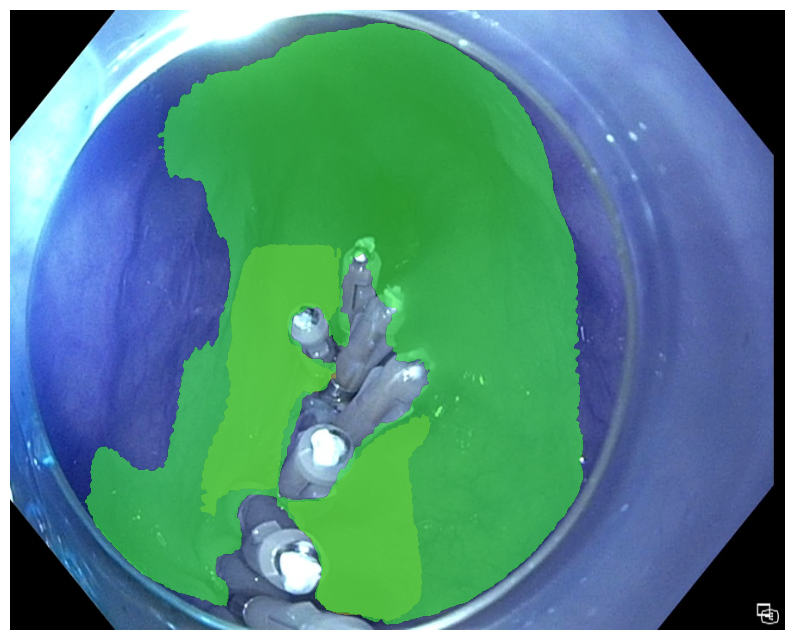

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box /in input_boxes:
#     show_box(+box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [29]:
image = cv2.imread("img.jpg")
image = image[:, 380:, :]

# image = cv2.imread("tiger.jpg")

In [30]:
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

26
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [31]:
segments = []
for mask in masks:
    segments.append(mask['segmentation'])

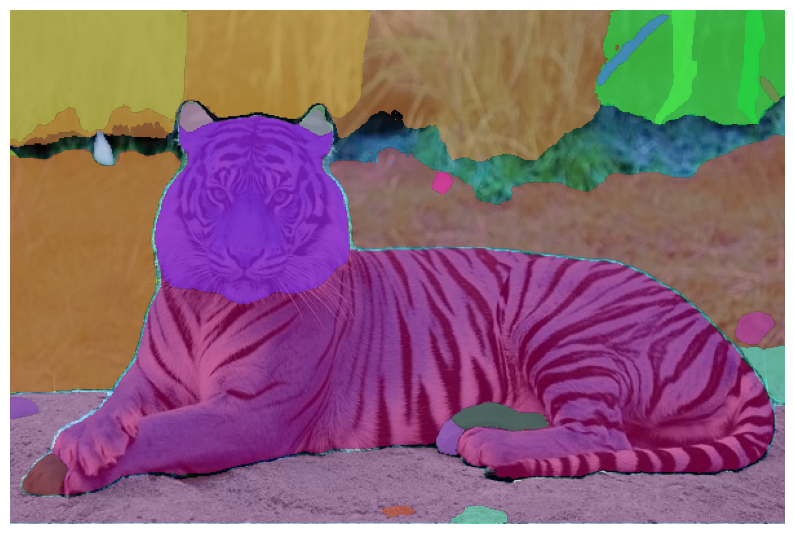

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in segments:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 